# *Model for Autoparam*

### Video Input
- Video Input
- Facial Recognition
- Sentiment Interpretation of Facial Expressions

### Selfimprovement
- Variable MIDI Inputs
- Account for Latency
- Measure Facial Expression Score as Y for MIDI X Params
- Figure out accounting for temporal measurements such as order, timing, speed
- Set update speed per param
- Send out next value for all MIDI params to change to for each param
- Repeat

### Send params via API
- Call Qt C++ Code to adjust params in VST (0 - 127 or 0.0 - 1.0)

## *Notes*
- Cropping face required for accurate performance

## *Verify Hardware Support*

In [2]:
# Silicon Mac Apple Accelleration
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print("MPS device", x)
else:
    print ("MPS device not found.")

MPS device tensor([1.], device='mps:0')


## *Coding*

### Video Input

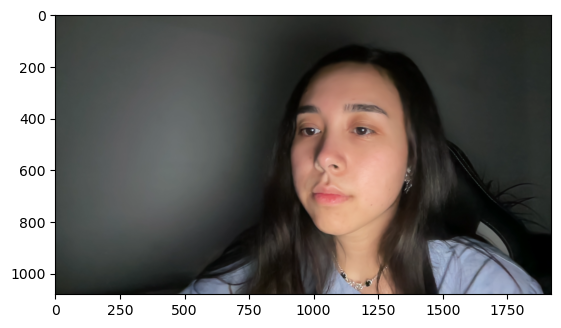

In [32]:
###
# VIDEO INPUT
### https://docs.opencv.org/4.x/
camera_id = 0
import cv2
import numpy as np
cap = cv2.VideoCapture(camera_id)

## get rgb frame
def shoot_image():
    ret, frame = cap.read()
    if not ret:
        return None
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return rgb_frame

## test image
import matplotlib.pyplot as plt
plt.imshow(shoot_image())
plt.show()  # Show the image

### Resnet

/Users/yc/anaconda3/envs/Autoparam/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


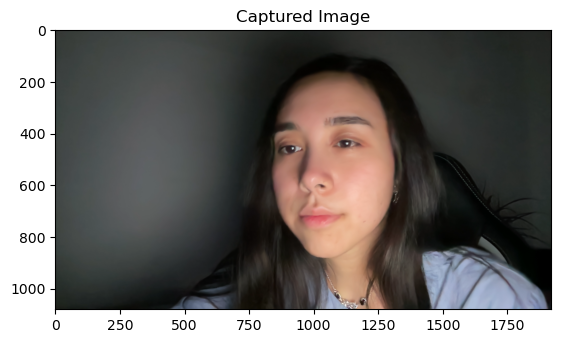

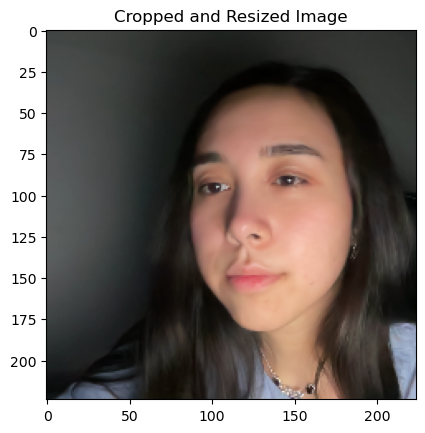

Processed tensor shape: torch.Size([1, 3, 224, 224])
Processed tensor values (min, max): -2.1007792949676514 2.552854299545288


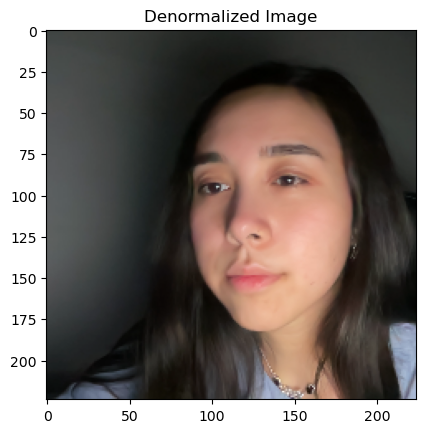

Top 5 Predictions:
seat belt: 0.6654
Band Aid: 0.0079
lab coat: 0.0068
necklace: 0.0056
neck brace: 0.0045


In [33]:
# RESNET SETUP
## simple pretrained model

import cv2
import numpy as np
import torch
import torchvision.models as models
from torchvision import transforms
import matplotlib.pyplot as plt

# Initialize camera
camera_id = 0
cap = cv2.VideoCapture(camera_id)

# Capture image
def shoot_image():
    ret, frame = cap.read()
    if not ret:
        return None
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    return rgb_frame

# Crop and resize image
def crop_and_resize(image, target_size=(224, 224)):
    # Get dimensions of the image
    h, w = image.shape[:2]
    
    # Center crop to make it square
    if h > w:
        start = (h - w) // 2
        end = start + w
        cropped = image[start:end, :]
    else:
        start = (w - h) // 2
        end = start + h
        cropped = image[:, start:end]
    
    # Resize to target size
    resized = cv2.resize(cropped, target_size)
    return resized

# Load ResNet50 model
resnet = models.resnet50(weights="IMAGENET1K_V2")
resnet.eval()

# Preprocess image
def process_frame(x):
    x = transforms.ToTensor()(x)
    x = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(x)
    x = x.unsqueeze(0)
    return x

# Denormalize image for visualization
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
    denorm = tensor * std + mean
    denorm = denorm.squeeze().permute(1, 2, 0).numpy()
    return denorm

# Capture and display raw image
img = shoot_image()
if img is not None:
    plt.imshow(img)
    plt.title("Captured Image")
    plt.show()
else:
    print("Failed to capture image from the camera.")

# Crop and resize the image
img_cropped_resized = crop_and_resize(img)
plt.imshow(img_cropped_resized)
plt.title("Cropped and Resized Image")
plt.show()

# Process image
x = process_frame(img_cropped_resized)
print("Processed tensor shape:", x.shape)
print("Processed tensor values (min, max):", x.min().item(), x.max().item())

# Denormalize and display processed image
denorm_img = denormalize(x)
plt.imshow(denorm_img)
plt.title("Denormalized Image")
plt.show()

# Make prediction
y = resnet(x)
probs = torch.nn.functional.softmax(y, dim=1)
top_probs, top_classes = torch.topk(probs, k=5)

# Print top 5 predictions
labels = models.ResNet50_Weights.IMAGENET1K_V2.meta["categories"]
print("Top 5 Predictions:")
for i in range(top_probs.shape[1]):
    print(f"{labels[top_classes[0][i].item()]}: {top_probs[0][i].item():.4f}")

# Release camera
cap.release()

In [43]:
labels_map = {"Surprise": 0, "Angry": 1, "Fear": 2, "Sad": 3, "Happy": 4, "?": 5}

### Emotion

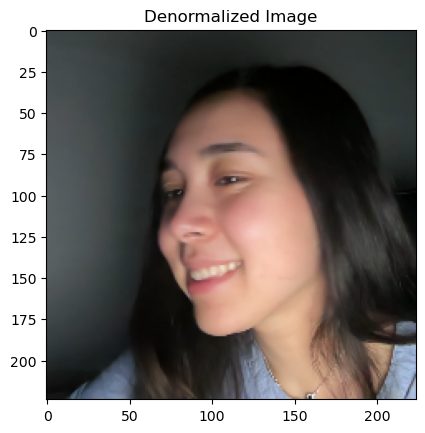

Top Predictions:
Happy: 0.9996
Sad: 0.0004
?: 0.0000
Fear: 0.0000
Surprise: 0.0000


In [60]:
# EMOTION DETECTION
camera_id = 0
import cv2
import numpy as np
cap = cv2.VideoCapture(camera_id)

## Test 
from safetensors.torch import load_file
img = shoot_image()
img = process_frame(crop_and_resize(img))

resnet = models.resnet50(pretrained=False)
resnet.fc = torch.nn.Linear(resnet.fc.in_features, 6)

# Load weights from .safetensors file
safetensors_path = "facialrecognition_resnet50/model.safetensors"  # Replace with your file path
state_dict = load_file(safetensors_path)
state_dict = {k.replace("resnet.", ""): v for k, v in state_dict.items()}
resnet.load_state_dict(state_dict=state_dict)
resnet.eval()

# Denormalize and display processed image
denorm_img = denormalize(img)
plt.imshow(denorm_img)
plt.title("Denormalized Image")
plt.show()

# Make prediction
y = resnet(img)
probs = torch.nn.functional.softmax(y, dim=1)
top_probs, top_classes = torch.topk(probs, k=5)

# Print top 5 predictions#

labels = ["Surprise", "Angry", "Fear", "Sad", "Happy", "?"]
print("Top Predictions:")
for i in range(top_probs.shape[1]):
    print(f"{labels[top_classes[0][i].item()]}: {top_probs[0][i].item():.4f}")


In [51]:
labels_map = {"Surprise": 0, "Angry": 1, "Fear": 2, "Sad": 3, "Happy": 4, "?": 5}
def get_sentiment_score(emotion_selection='Happy'):
    """
    Get Sentiment score.
    """
    img = process_frame(crop_and_resize(shoot_image()))
    y = resnet(img)
    probs = torch.nn.functional.softmax(y, dim=1)
    return torch.topk(probs, k=5)[0][0][labels_map[emotion_selection]]

# *Selfimprovement*
- Variable MIDI Inputs
- Account for Latency
- Measure Facial Expression Score as Y for MIDI X Params
- Figure out accounting for temporal measurements such as order, timing, speed
- Set update speed per param
- Send out next value for all MIDI params to change to for each param
- Repeat

In [46]:
# PARAMETERS
n_midi_params = 5

# MIDI OUTPUT
import numpy as np
import time
import gym
from gym import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import mido

## init outputs
try:
    midi_out = mido.open_output('Virtual MIDI Port', virtual=True)  # Create a virtual MIDI port
    print("MIDI output port opened successfully.")
except Exception as e:
    print(f"Failed to open MIDI output port: {e}")
    midi_out = None


## init as random
midi_params = np.random.randint(0, 128, size=n_midi_params)

## send midi control change messages
def send_midi_data(params):
    """
    Send MIDI control change messages for each parameter.
    """
    if midi_out is not None:
        for i, value in enumerate(params):
            # Send control change message (channel 0, control number i, value)
            msg = mido.Message('control_change', control=i, value=int(value))
            midi_out.send(msg)
            # print(f"Sent MIDI message: {msg}")

def smooth_transition(start_params, end_params, ms_length=2000):
    """
    Smoothly transition from start_params to end_params over ms_length milliseconds.
    """
    steps = 100  # Number of interpolation steps
    delay = ms_length / steps  # Time delay between steps

    for i in range(steps):
        # Linear interpolation
        current_params = start_params + (end_params - start_params) * (i / steps)
        current_params = np.clip(current_params, 0, 127)  # Clip to valid MIDI range
        # print("Current MIDI Parameters:", current_params)

        # Send MIDI data
        send_midi_data(current_params)

        time.sleep(delay / 1000)  # Convert ms to seconds

MIDI output port opened successfully.


In [47]:
# MAP SIGNAL
for i in range(n_midi_params):
    # TEST SIGNAL
    for _ in range(100):
        msg = mido.Message('control_change', control=i, value=int(42))
        midi_out.send(msg)
        time.sleep(0.1)
    print('Done for signal', i)
    input('Press enter to continue, next Parameter')
print("Done!")

Done for signal 0
Done for signal 1
Done for signal 2
Done for signal 3
Done for signal 4
Done!


In [50]:
# REINFORCEMENT LEARNING
## Gym Environment
class MidiSentimentEnv(gym.Env):
    def __init__(self):
        super(MidiSentimentEnv, self).__init__()
        # Define action and observation space
        self.action_space = spaces.Box(low=-10, high=10, shape=(n_midi_params,), dtype=np.float32)  # Interval changes
        self.observation_space = spaces.Box(low=0, high=127, shape=(n_midi_params,), dtype=np.float32)  # MIDI parameters
        self.i = 0
        # Initialize state
        self.state = np.random.randint(0, 128, size=n_midi_params)
        self.ms_length = 2000  # Initial time window
    
    def seed(self, seed=None):
        np.random.seed(seed)

    def reset(self):
        # Reset the environment to an initial state
        self.state = np.random.randint(0, 128, size=n_midi_params)
        return self.state

    def step(self, action):
        print(self.i)
        self.i += 1
        action = action.astype(int)  # Convert action to integer
        self.state += action  # Now self.state remains int64
        self.state = np.clip(self.state, 0, 127)  # Clip to valid MIDI range

        # send_midi_data(self.state)
        target_params = np.random.randint(0, 128, size=n_midi_params)
        smooth_transition(midi_params, target_params)
        
        sentiment_score = get_sentiment_score()
        reward = sentiment_score
        done = False  # Infinite episode

        return self.state, reward, done, {}

    def render(self, mode='human'):
        # Optional: Visualize the environment
        print("Current MIDI Parameters:", self.state)

In [ ]:
# Create the environment
env = make_vec_env(MidiSentimentEnv, n_envs=1)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=10000)

# # Save the model
model.save("midi_sentiment_rl_model")
model = PPO.load("midi_sentiment_rl_model")

# Run the model in the environment
obs = env.reset()
for _ in range(1000):
    print(_)
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    print(f"Action: {action}, Reward: {rewards}")

Using cpu device
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


KeyboardInterrupt: 